1. Setup and Data Loading

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define transformations for the training and test data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


2. Visualizing Some Training Images

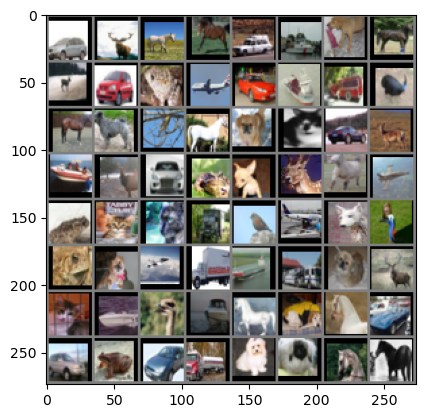

car   deer  horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{classes[labels[j]]:5}' for j in range(4)))


3. Defining a Convolutional Neural Network (CNN)

In [7]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()


4. Defining Loss Function and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)


5. Parameter Tuning

In [11]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.001, 0.0001],
    'batch_size': [32, 64]
}

best_acc = 0
best_params = {}

for params in ParameterGrid(param_grid):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True, num_workers=2)
    optimizer = optim.Adam(net.parameters(), lr=params['lr'])
    
    # Training loop
    for epoch in range(10):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}')

    # Evaluate on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if accuracy > best_acc:
        best_acc = accuracy
        best_params = params

print(f'Best Accuracy: {best_acc}% with params: {best_params}')


Epoch 1, Loss: 1.4416840145470466
Epoch 2, Loss: 1.0871633633694737
Epoch 3, Loss: 0.947987856787897
Epoch 4, Loss: 0.8665344745244876
Epoch 5, Loss: 0.8108884201588268
Epoch 6, Loss: 0.7689108964120129
Epoch 7, Loss: 0.7371050520196453
Epoch 8, Loss: 0.7066985534424212
Epoch 9, Loss: 0.6800111874375523
Epoch 10, Loss: 0.6548309144936383
Epoch 1, Loss: 0.5598380397945661
Epoch 2, Loss: 0.5410544624312597
Epoch 3, Loss: 0.5267700436819995
Epoch 4, Loss: 0.5219920879171509
Epoch 5, Loss: 0.5161310943774283
Epoch 6, Loss: 0.5075393475482499
Epoch 7, Loss: 0.5024527074412818
Epoch 8, Loss: 0.49656806587791563
Epoch 9, Loss: 0.4883332596811742
Epoch 10, Loss: 0.4861548208534451
Epoch 1, Loss: 0.5620373843042442
Epoch 2, Loss: 0.5542998186424565
Epoch 3, Loss: 0.5483089417905149
Epoch 4, Loss: 0.5360993252271582
Epoch 5, Loss: 0.531027494336638
Epoch 6, Loss: 0.5190580368537427
Epoch 7, Loss: 0.5033613128773392
Epoch 8, Loss: 0.5012413628608979
Epoch 9, Loss: 0.4921521685083809
Epoch 10, Los

6. Training the Network with Best Parameters

In [13]:
# Use the best parameters found
trainloader = torch.utils.data.DataLoader(trainset, batch_size=best_params['batch_size'], shuffle=True, num_workers=2)
optimizer = optim.Adam(net.parameters(), lr=best_params['lr'])

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:
            print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')


[1, 200] loss: 0.368
[1, 400] loss: 0.369
[1, 600] loss: 0.363
[2, 200] loss: 0.359
[2, 400] loss: 0.377
[2, 600] loss: 0.361
[3, 200] loss: 0.364
[3, 400] loss: 0.378
[3, 600] loss: 0.358
[4, 200] loss: 0.358
[4, 400] loss: 0.365
[4, 600] loss: 0.367
[5, 200] loss: 0.363
[5, 400] loss: 0.366
[5, 600] loss: 0.354
[6, 200] loss: 0.370
[6, 400] loss: 0.351
[6, 600] loss: 0.359
[7, 200] loss: 0.346
[7, 400] loss: 0.357
[7, 600] loss: 0.349
[8, 200] loss: 0.345
[8, 400] loss: 0.360
[8, 600] loss: 0.349
[9, 200] loss: 0.347
[9, 400] loss: 0.353
[9, 600] loss: 0.341
[10, 200] loss: 0.358
[10, 400] loss: 0.350
[10, 600] loss: 0.342
Finished Training


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy} %')


Accuracy of the network on the 10000 test images: 81.41 %


In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print(f'Accuracy of {classes[i]:5} : {100 * class_correct[i] / class_total[i]:.2f} %')



Accuracy of plane : 91.07 %
Accuracy of car   : 92.00 %
Accuracy of bird  : 73.42 %
Accuracy of cat   : 67.12 %
Accuracy of deer  : 74.55 %
Accuracy of dog   : 69.49 %
Accuracy of frog  : 94.64 %
Accuracy of horse : 84.38 %
Accuracy of ship  : 94.83 %
Accuracy of truck : 88.46 %


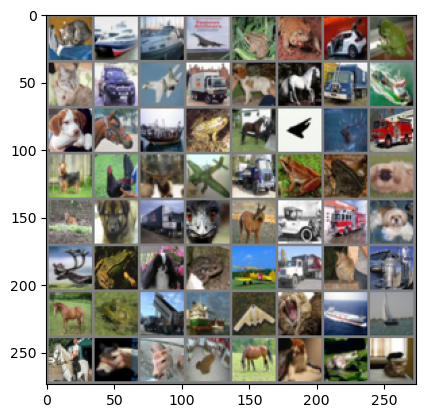

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


In [23]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5}' for j in range(4)))

outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5}' for j in range(4)))
